In [28]:
from ammgammalib import *
from rpathlib import *
from matplotlib import pyplot as plt
import numpy as np
print("AMMGammaLib version {0.__VERSION__} ({0.__DATE__})".format(AMMSim))
print("RPathLib version {0.__VERSION__} ({0.__DATE__})".format(RPath))

AMMGammaLib version 1.2 (26/Dec/2022)
RPathLib version 1.1 (26/Dec/2022)


In [29]:
STARTT = recordtime(init=True)

RECORDTIME -- Starting recording


# AMM Gamma vs Derivatives Gamma (Book 2)

## Demo of toolkit used
### Random path generation

We are drawing paths from a lognormal distribution. The raw paths are relatively high frequency (sub-hour sampling)

N=1000, T=0.0m=1.0d; Period=0.0010d=0.02h


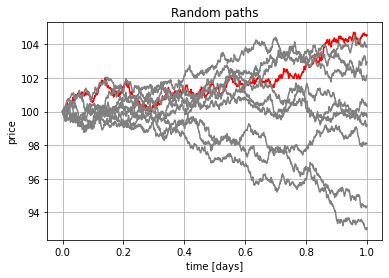

In [30]:
PG = RPathGen(LOGNORM, sig=0.5, T=1/365, N=1000)
paths = PG.generate(10, tuple)
p0 = paths[0]
print(f"N={p0.N0}, T={p0.T*12:0.1f}m={p0.T*364:0.1f}d; Period={p0.periodtime0*365:0.4f}d={p0.periodtime0*365*24:0.2f}h")
for p in paths:
    plt.plot(p.time0*365, p.path0, color="grey" if p!=p0 else "red")
plt.title("Random paths")
plt.xlabel("time [days]")
plt.ylabel("price")
plt.grid()

The paths can then be sampled down using the `period` parameter. Eg `period=10` skips 9 samples at every time, so the sampling frequency is reduced by a factor of 10. Here we show `period=50` and `period=100`. Note that the first and last periods can be short as (if `bounds = True`) the bounds are always included.

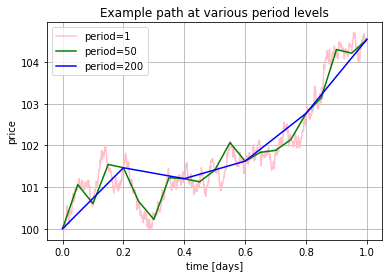

In [31]:
p1 = p0(period=50)
p2 = p0(period=200)
plt.plot(p0.time0*365, p0.path0, color="pink", label=f"period={p0.period}")
plt.plot(p1.time()*365, p1.path(), color="green", label=f"period={p1.period}")
plt.plot(p2.time()*365, p2.path(), color="blue", label=f"period={p2.period}")
plt.title("Example path at various period levels")
plt.xlabel("time [days]")
plt.ylabel("price")
plt.legend()
plt.grid()

There is also an `offset` parameter that -- for a given period -- moves the window around.

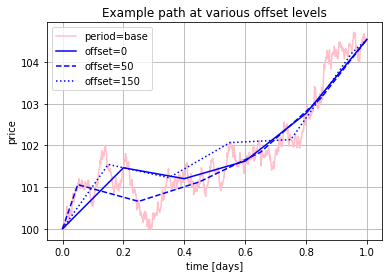

In [32]:
p2a = p2(offset=50)
p2b = p2(offset=150)
plt.plot(p0.time0*365, p0.path0, color="pink", label=f"period=base")
plt.plot(p2.time()*365, p2.path(), color="blue", label=f"offset={p2.offset}")
plt.plot(p2a.time()*365, p2a.path(), color="blue", linestyle="dashed", label=f"offset={p2a.offset}")
plt.plot(p2b.time()*365, p2b.path(), color="blue", linestyle="dotted", label=f"offset={p2b.offset}")
plt.title("Example path at various offset levels")
plt.xlabel("time [days]")
plt.ylabel("price")
plt.legend()
plt.grid()

### AMMSim

Basis `AMMSim` functionality: only execute `trade_to` when `bleed` (=arbitrageur's earnings) is bigger or equal `fee` (=arbitrageurs's payments).

In [33]:
sim = AMMSim(p0=100, feepc=0.10)
t = sim.trade_to(150)
print(f"p={sim.p_marg}, bleed={t.bleed:0.2f}, fee={t.fee:0.2f}, reverted={t.reverted}")
t = sim.trade_to(130)
print(f"p={sim.p_marg}, bleed={t.bleed:0.2f}, fee={t.fee:0.2f}, reverted={t.reverted}")
t = sim.trade_to(100)
print(f"p={sim.p_marg}, bleed={t.bleed:0.2f}, fee={t.fee:0.2f}, reverted={t.reverted}")

p=150.0, bleed=2.53, fee=1.12, reverted=False
p=150.0, bleed=0.29, fee=0.42, reverted=True
p=100.0, bleed=2.06, fee=1.12, reverted=False


A simple sim using the path generator built into the sim library. Note the number of segments itself is random.

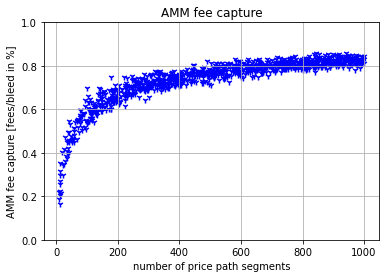

In [34]:
sims = []
for _ in range(1000):
    p_r = create_prices(0.2, np.random.randint(10,1000))
    sim = AMMSim(p0=100,feepc=0.01)
    sims += [sim]
    for p in p_r:
        sim.trade_to(p)

plt.scatter([s.ntrades for s in sims], [s.ammvalcapturepc for s in sims], marker="1", color="blue")
plt.title("AMM fee capture")
plt.xlabel("number of price path segments")
plt.ylabel("AMM fee capture [fees/bleed in %]")
plt.ylim(0,1)
plt.grid()

#### Create a sim using path generator

We first create a series of path. The chart show the first one.

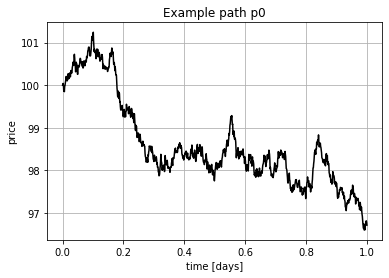

In [35]:
PG = RPathGen(LOGNORM, sig=0.5, T=1/365, N=1000)
paths = PG.generate(100, tuple)
p0 = paths[0]
plt.plot(p0.time0*365, p0.path0, color="black")
plt.title("Example path p0")
plt.xlabel("time [days]")
plt.ylabel("price")
#plt.legend()
plt.grid()

We now show how to run a single path through the simulator

In [36]:
sim = AMMSim(p0=100, tvl0=1000000, feepc=0.005)
for p in p0.path0:
    sim.trade_to(p)

print(f"number trades:              {sim.ntrades:7}")
print(f"number passed:              {sim.npassed:7}")
print(f"number reverted:            {sim.nreverted:7}")
print(f"perc reverted:              {sim.pcreverted*100:10.2f} %")
print()
print(f"Total value capture:        {sim.totalvalcapture*100:10,.2f} USD")
print(f" percent:                   {100:10.2f} %")
print(f"AMM value capture:          {sim.ammvalcapture*100:10,.2f} USD")
print(f" percent:                   {sim.ammvalcapturepc*100:10.2f} %")
print(f"Arb value capture:          {sim.arbvalcapture*100:10,.2f} USD")
print(f" percent:                   {sim.arbvalcapturepc*100:10.2f} %")


number trades:                 1000
number passed:                    7
number reverted:                993
perc reverted:                   99.30 %

Total value capture:          9,844.50 USD
 percent:                       100.00 %
AMM value capture:            9,255.94 USD
 percent:                        94.02 %
Arb value capture:              588.56 USD
 percent:                         5.98 %


Now we scale the same(!) path down by using a different `period` length, and run variations by changing the `offset`.

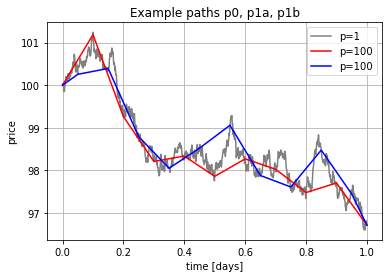

In [37]:
p1a = p0(period=100)
p1b = p1a(offset=50)
sims = []
for p_, col in [(p0, "grey"), (p1a, "red"), (p1b, "blue")]:
    sim = AMMSim(p0=100, tvl0=1000000, feepc=0.005)
    for prc in p_.path():
        sim.trade_to(prc)
    sims += [(sim, p_)]
    plt.plot(p_.time()*365, p_.path(), color=col, label=f"p={p_.period}")
plt.title("Example paths p0, p1a, p1b")
plt.xlabel("time [days]")
plt.ylabel("price")
plt.legend()
plt.grid()

In [38]:
for sim, p_ in sims:
    print(f"period:                     {p_.period:7}")
    print(f"offset:                     {p_.offset:7}")
    print(f"number trades:              {sim.ntrades:7}")
    print(f"number passed:              {sim.npassed:7}")
    print(f"number reverted:            {sim.nreverted:7}")
    print(f"perc reverted:              {sim.pcreverted*100:10.2f} %")
    print(f"Total value capture:        {sim.totalvalcapture*100:10,.2f} USD")
    print(f" percent:                   {100:10.2f} %")
    print(f"AMM value capture:          {sim.ammvalcapture*100:10,.2f} USD")
    print(f" percent:                   {sim.ammvalcapturepc*100:10.2f} %")
    print(f"Arb value capture:          {sim.arbvalcapture*100:10,.2f} USD")
    print(f" percent:                   {sim.arbvalcapturepc*100:10.2f} %")
    print("---")

period:                           1
offset:                           0
number trades:                 1000
number passed:                    7
number reverted:                993
perc reverted:                   99.30 %
Total value capture:          9,844.50 USD
 percent:                       100.00 %
AMM value capture:            9,255.94 USD
 percent:                        94.02 %
Arb value capture:              588.56 USD
 percent:                         5.98 %
---
period:                         100
offset:                           0
number trades:                   10
number passed:                    4
number reverted:                  6
perc reverted:                   60.00 %
Total value capture:         10,638.04 USD
 percent:                       100.00 %
AMM value capture:            7,099.06 USD
 percent:                        66.73 %
Arb value capture:            3,538.98 USD
 percent:                        33.27 %
---
period:                         100
offset:   

In [39]:
recordtime("Section")

RECORDTIME --  1.9s [Section]


1.9390959739685059

## Analysis proper

In [40]:
MAX_PERIOD=202

In [41]:
def run_analysis(feepc):
    PG = RPathGen(LOGNORM, sig=0.5, T=1/365, N=1000)
    sim0 = AMMSim(p0=100, tvl0=1000000, feepc=feepc)
    sims = {period:[] for period in range(1,MAX_PERIOD,5)}
    paths = PG.generate(1000)
    for p_ in paths:
        #print ("===NEW PATH===")
        for period in sims:
            sim = sim0.copy()
            #print("trades", sim.ntrades)
            p__=p_(period=period)
            for prc in p__.path():
                sim.trade_to(prc)
            sims[period] += [sim]

    sims_aggr = {
        period: sim0.aggregate(simlist)
        for period, simlist in sims.items()
    }
    return sims_aggr

### fees = 2%

In [42]:
sims_aggr_0200 = run_analysis(feepc=0.02)
recordtime("Monte Carlo")

RECORDTIME -- 14.6s [Monte Carlo]


14.597594022750854

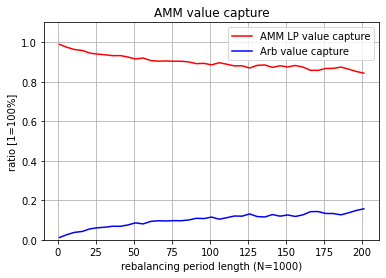

In [43]:
plt.plot(sims_aggr_0200.keys(), [sim.ammvalcapturepc for sim in sims_aggr_0200.values()], color="red", label="AMM LP value capture")
plt.plot(sims_aggr_0200.keys(), [sim.arbvalcapturepc for sim in sims_aggr_0200.values()], color="blue", label="Arb value capture")
plt.title("AMM value capture")
plt.xlabel(f"rebalancing period length (N={p_.N0})")
plt.ylim(0,1.1)
plt.ylabel("ratio [1=100%]")
plt.legend()
plt.grid()

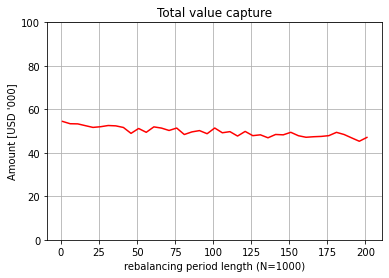

In [44]:
plt.plot(sims_aggr_0200.keys(), [sim.totalvalcapture/1000 for sim in sims_aggr_0200.values()], color="red")
plt.title("Total value capture")
plt.xlabel(f"rebalancing period length (N={p_.N0})")
plt.ylim(0,100)
plt.ylabel("Amount [USD '000]")
plt.grid()

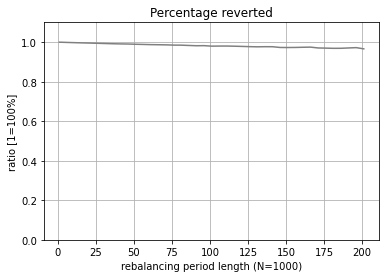

In [45]:
plt.plot(sims_aggr_0200.keys(), [sim.pcreverted for sim in sims_aggr_0200.values()],color="grey")
plt.title("Percentage reverted")
plt.xlabel(f"rebalancing period length (N={p_.N0})")
plt.ylim(0,1.1)
plt.ylabel("ratio [1=100%]")
plt.grid()

### fees = 0.5%

In [46]:
sims_aggr_0050 = run_analysis(feepc=0.005)
recordtime("Monte Carlo")

RECORDTIME -- 27.4s [Monte Carlo]


27.35102891921997

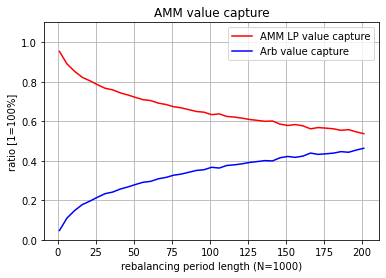

In [47]:
plt.plot(sims_aggr_0050.keys(), [sim.ammvalcapturepc for sim in sims_aggr_0050.values()], color="red", label="AMM LP value capture")
plt.plot(sims_aggr_0050.keys(), [sim.arbvalcapturepc for sim in sims_aggr_0050.values()], color="blue", label="Arb value capture")
plt.title("AMM value capture")
plt.xlabel(f"rebalancing period length (N={p_.N0})")
plt.ylim(0,1.1)
plt.ylabel("ratio [1=100%]")
plt.legend()
plt.grid()

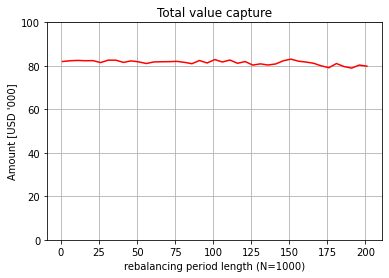

In [48]:
plt.plot(sims_aggr_0050.keys(), [sim.totalvalcapture/1000 for sim in sims_aggr_0050.values()], color="red")
plt.title("Total value capture")
plt.xlabel(f"rebalancing period length (N={p_.N0})")
plt.ylim(0,100)
plt.ylabel("Amount [USD '000]")
plt.grid()

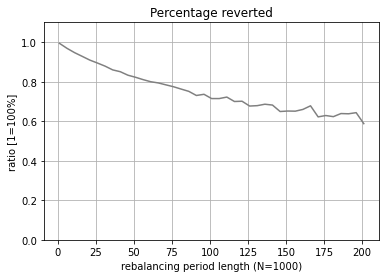

In [49]:
plt.plot(sims_aggr_0050.keys(), [sim.pcreverted for sim in sims_aggr_0050.values()],color="grey")
plt.title("Percentage reverted")
plt.xlabel(f"rebalancing period length (N={p_.N0})")
plt.ylim(0,1.1)
plt.ylabel("ratio [1=100%]")
plt.grid()

### fees = 0

In [50]:
sims_aggr_0000 = run_analysis(feepc=0)
recordtime("Monte Carlo")

RECORDTIME -- 40.2s [Monte Carlo]


40.22433519363403

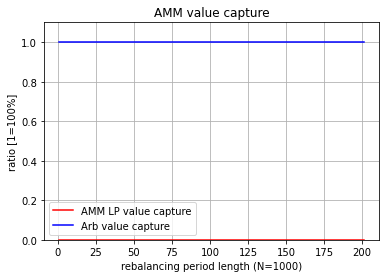

In [51]:
plt.plot(sims_aggr_0000.keys(), [sim.ammvalcapturepc for sim in sims_aggr_0000.values()], color="red", label="AMM LP value capture")
plt.plot(sims_aggr_0000.keys(), [sim.arbvalcapturepc for sim in sims_aggr_0000.values()], color="blue", label="Arb value capture")
plt.title("AMM value capture")
plt.xlabel(f"rebalancing period length (N={p_.N0})")
plt.ylim(0,1.1)
plt.ylabel("ratio [1=100%]")
plt.legend()
plt.grid()

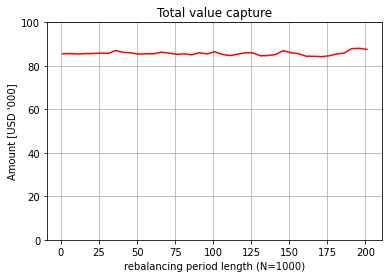

In [52]:
plt.plot(sims_aggr_0000.keys(), [sim.totalvalcapture/1000 for sim in sims_aggr_0000.values()], color="red")
plt.title("Total value capture")
plt.xlabel(f"rebalancing period length (N={p_.N0})")
plt.ylim(0,100)
plt.ylabel("Amount [USD '000]")
plt.grid()

### Aggregate

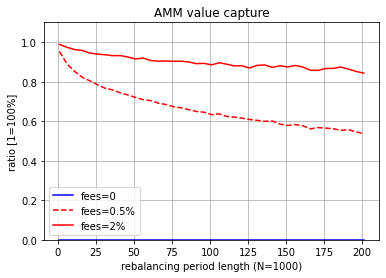

In [53]:
plt.plot(sims_aggr_0000.keys(), [sim.ammvalcapturepc for sim in sims_aggr_0000.values()], color="blue", label="fees=0")
plt.plot(sims_aggr_0050.keys(), [sim.ammvalcapturepc for sim in sims_aggr_0050.values()], color="red", linestyle="dashed", label="fees=0.5%")
plt.plot(sims_aggr_0200.keys(), [sim.ammvalcapturepc for sim in sims_aggr_0200.values()], color="red", linestyle="solid", label="fees=2%")
plt.title("AMM value capture")
plt.xlabel(f"rebalancing period length (N={p_.N0})")
plt.ylim(0,1.1)
plt.ylabel("ratio [1=100%]")
plt.legend()
plt.grid()

## End

In [54]:
recordtime("Final")

RECORDTIME -- 40.5s [Final]


40.48701000213623